In [1]:
import sys, os, time, datetime, csv
sys.path.insert(1, '/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/tools')
from tools import *
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm
from matplotlib.lines import Line2D

from trackml.dataset import load_event

import pandas as pd

from mpl_toolkits import mplot3d


from collections import namedtuple

import numpy as np

# A Graph is a namedtuple of matrices (X, Ri, Ro, y)
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])

def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

def save_graph(graph, filename):
    """Write a single graph to an NPZ file archive"""
    np.savez(filename, **graph_to_sparse(graph))

def save_graphs(graphs, filenames):
    for graph, filename in zip(graphs, filenames):
        save_graph(graph, filename)

def load_graph(filename):
    """Reade a single graph NPZ"""
    with np.load(filename) as f:
        return sparse_to_graph(**dict(f.items()))

def load_graphs(filenames, graph_type=Graph):
    return [load_graph(f, graph_type) for f in filenames]


def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)



In [18]:
train_small=['000001066', '000001067', '000001083', '000001082', '000001011', '000001010', '000001058', '000001059', '000001052', '000001053', '000001089', '000001088', '000001071', '000001070', '000001038', '000001039',  '000001006', '000001007', '000001094', '000001095', '000001045', '000001044', '000001076', '000001077', '000001048', '000001049', '000001093', '000001092', '000001001', '000001000', '000001099', '000001098', '000001042', '000001043', '000001028', '000001029', '000001061', '000001060', '000001016', '000001017', '000001084', '000001085', '000001055', '000001054', '000001078', '000001079', '000001046', '000001047', '000001072', '000001073']

In [19]:
train_small=np.array(train_small)

In [20]:
val_list=[]
for i in range(len(train_small)):
    i_val=int(train_small[i])
    val_list.append(i_val)
               

In [21]:
np.sort(np.array(val_list))

array([1000, 1001, 1006, 1007, 1010, 1011, 1016, 1017, 1028, 1029, 1038,
       1039, 1042, 1043, 1044, 1045, 1046, 1047, 1048, 1049, 1052, 1053,
       1054, 1055, 1058, 1059, 1060, 1061, 1066, 1067, 1070, 1071, 1072,
       1073, 1076, 1077, 1078, 1079, 1082, 1083, 1084, 1085, 1088, 1089,
       1092, 1093, 1094, 1095, 1098, 1099])

In [32]:
train_graphs=os.listdir('/Users/lucascurtin/Desktop/edge_data/train_graphs')
valid_graphs=os.listdir('/Users/lucascurtin/Desktop/edge_data/valid_graphs')
event_train_names=[]
event_valid_names=[]
for i in range(len(train_graphs)):
    name_i=train_graphs[i][5:14]
    event_train_names.append(name_i)
for i in range(len(valid_graphs)):
    name_i=valid_graphs[i][5:14]
    event_valid_names.append(name_i)


In [38]:
print(event_train_names[0:51])

['000001066', '000001067', '000001083', '000001082', '000001011', '000001010', '000001058', '000001059', '000001052', '000001053', '000001089', '000001088', '000001071', '000001070', '000001038', '000001039', 'tore', '000001006', '000001007', '000001094', '000001095', '000001045', '000001044', '000001076', '000001077', '000001048', '000001049', '000001093', '000001092', '000001001', '000001000', '000001099', '000001098', '000001042', '000001043', '000001028', '000001029', '000001061', '000001060', '000001016', '000001017', '000001084', '000001085', '000001055', '000001054', '000001078', '000001079', '000001046', '000001047', '000001072', '000001073']


In [2]:
cols = [ 'edge', 'label', 'eta', 'phi', 'true_pt', 'layer', 'track_length', 'hit1_id', 'hit2_id', 'particle_num'] #suggested column names
event = pd.DataFrame(np.load('/Users/lucascurtin/Desktop/edge_data/preprocessed_edges_1000_1099/edges_preprocessed_000001000.npy',allow_pickle = True), columns = cols)

true_events=event.loc[event['label'] == 1]

fake_events=event.loc[event['label'] == 0]


In [3]:
event

,edge,label,eta,phi,true_pt,layer,track_length,hit1_id,hit2_id,particle_num
0,"[31.496714, -1.2947888, 44.7477, 72.56859, -1....",1,1.11799,"[-1.2947888, -1.3045837]","[1.4319831132888794, 1.4319831132888794]",82,"[7, 7]",00000100010017,00000100010017,1095
1,"[31.496714, -1.2947888, 44.7477, 72.45377, -1....",0,-1.049843,"[-1.2947888, -1.2949874]","[1.4319831132888794, 1.157448649406433]",82,"[7, 9]",00000100010017,0000010003481,1095
2,"[31.496714, -1.2947888, 44.7477, 72.3823, -1.2...",0,1.095215,"[-1.2947888, -1.2886992]","[1.4319831132888794, 1.5366206169128418]",82,"[7, 8]",00000100010017,0000010004332,1095
3,"[31.496714, -1.2947888, 44.7477, 71.79107, -1....",0,2.065377,"[-1.2947888, -1.2802732]","[1.4319831132888794, 1.389689326286316]",82,"[7, 6]",00000100010017,0000010004753,1095
4,"[31.935396, -2.7976387, -24.3397, 71.77119, -2...",1,-0.745732,"[-2.7976387, -2.7868211]","[1.1499686241149902, 1.1499686241149902]",82,"[7, 7]",00000100010026,00000100010026,1095
...,...,...,...,...,...,...,...,...,...,...
10668,"[820.3942, -1.5300422, 151.6, 1023.5756, -1.49...",1,0.186919,"[-1.5300422, -1.4959512]","[1.8084810972213745, 1.8084810972213745]",172,"[10, 10]",0000010009880,0000010009880,1095
10669,"[817.7667, -0.81763387, -130.0, 1021.2284, -0....",1,-0.134265,"[-0.81763387, -0.8491727]","[1.973840594291687, 1.973840594291687]",172,"[10, 10]",0000010009881,0000010009881,1095
10670,"[819.30994, -0.9875191, -623.4, 1022.1961, -1....",1,-0.692498,"[-0.9875191, -1.049645]","[1.0365803241729736, 1.0365803241729736]",172,"[9, 9]",0000010009927,0000010009927,1095
10671,"[820.3252, -1.8162135, 179.0, 1019.38654, -1.7...",1,0.21535,"[-1.8162135, -1.7712139]","[1.3330026865005493, 1.3330026865005493]",172,"[5, 5]",0000010009929,0000010009929,1095


In [9]:
layers=np.unique(event['layer'])

In [18]:
v = event[event.layer == layers[0]]
x_i,y_i,z_i=v['edge'].iloc[0][0:3]
x_o,y_o,z_o=v['edge'].iloc[0][3:6]

#ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(layer_ids), alpha=0.5)

In [27]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('/Users/lucascurtin/Desktop/TrackML/train_100_events', event_prefix))

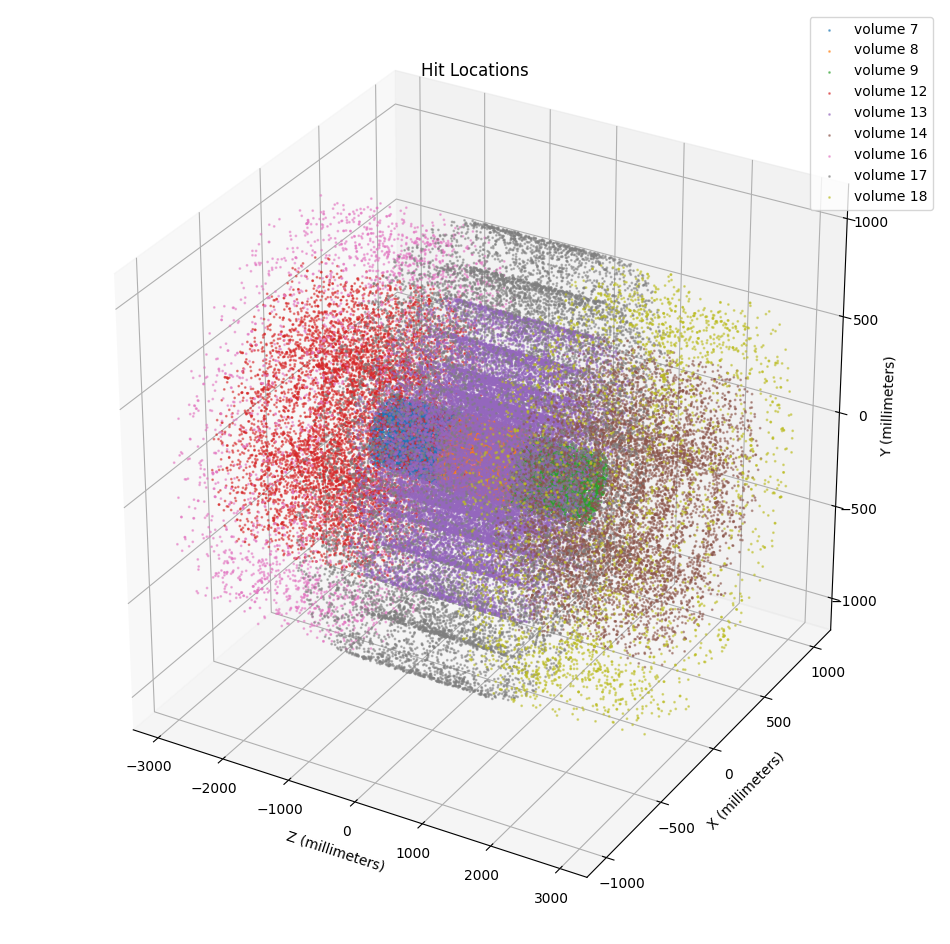

In [36]:
volumes = hits.volume_id.unique()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for volume in volumes:
    v = hits[hits.volume_id == volume]
    ax.scatter(v.z, v.x, v.y, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

In [34]:
event

,edge,label,eta,phi,true_pt,layer,track_length,hit1_id,hit2_id,particle_num
0,"[31.496714, -1.2947888, 44.7477, 72.56859, -1....",1,1.11799,"[-1.2947888, -1.3045837]","[1.4319831132888794, 1.4319831132888794]",82,"[7, 7]",00000100010017,00000100010017,1095
1,"[31.496714, -1.2947888, 44.7477, 72.45377, -1....",0,-1.049843,"[-1.2947888, -1.2949874]","[1.4319831132888794, 1.157448649406433]",82,"[7, 9]",00000100010017,0000010003481,1095
2,"[31.496714, -1.2947888, 44.7477, 72.3823, -1.2...",0,1.095215,"[-1.2947888, -1.2886992]","[1.4319831132888794, 1.5366206169128418]",82,"[7, 8]",00000100010017,0000010004332,1095
3,"[31.496714, -1.2947888, 44.7477, 71.79107, -1....",0,2.065377,"[-1.2947888, -1.2802732]","[1.4319831132888794, 1.389689326286316]",82,"[7, 6]",00000100010017,0000010004753,1095
4,"[31.935396, -2.7976387, -24.3397, 71.77119, -2...",1,-0.745732,"[-2.7976387, -2.7868211]","[1.1499686241149902, 1.1499686241149902]",82,"[7, 7]",00000100010026,00000100010026,1095
...,...,...,...,...,...,...,...,...,...,...
10668,"[820.3942, -1.5300422, 151.6, 1023.5756, -1.49...",1,0.186919,"[-1.5300422, -1.4959512]","[1.8084810972213745, 1.8084810972213745]",172,"[10, 10]",0000010009880,0000010009880,1095
10669,"[817.7667, -0.81763387, -130.0, 1021.2284, -0....",1,-0.134265,"[-0.81763387, -0.8491727]","[1.973840594291687, 1.973840594291687]",172,"[10, 10]",0000010009881,0000010009881,1095
10670,"[819.30994, -0.9875191, -623.4, 1022.1961, -1....",1,-0.692498,"[-0.9875191, -1.049645]","[1.0365803241729736, 1.0365803241729736]",172,"[9, 9]",0000010009927,0000010009927,1095
10671,"[820.3252, -1.8162135, 179.0, 1019.38654, -1.7...",1,0.21535,"[-1.8162135, -1.7712139]","[1.3330026865005493, 1.3330026865005493]",172,"[5, 5]",0000010009929,0000010009929,1095


In [31]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
for layer_ids in layers:
    v = event[event.layer == layer_ids]
    for i in range(len(v)):
        r_i,theta_i,z_i=v['edge'].iloc[i][0:3]
        r_o,theta_o,z_o=v['edge'].iloc[i][3:6]
        x_i=r_i*(np.cos(theta_i))
        y_i=r_i*(np.sin(theta_i))
        x_o=r_o*(np.cos(theta_o))
        y_o=r_o*(np.sin(theta_o))

        if layer_ids==132 or 134 or 136:
            volume=13
        
        if layer_ids==172:
            volume=17

        if layer_ids==82 or 84 or 86 or 88:
            volume=8
        ax.scatter(x_i, y_i, z_i, s=1, label='volume {}'.format(volume), alpha=0.5)
        ax.scatter(x_o, y_o, z_o, s=1, label='volume {}'.format(volume), alpha=0.5)
ax.set_title('Hit Locations')
ax.set_xlabel('Z (millimeters)')
ax.set_ylabel('X (millimeters)')
ax.set_zlabel('Y (millimeters)')
ax.legend()
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe4eca36550> (for post_execute):


KeyboardInterrupt: 

In [12]:
n_section=1
theta_counter = np.pi/n_section # start 45 degree rotated

X, Ri, Ro, y = load_graph('/Users/lucascurtin/Desktop/QGNN Repos/qtrkx-gnn-tracking/data_personal/tuysuz_original/train/event000001000_g000.npz')
X[:,1] = X[:,1] * np.pi/n_section
theta = (X[:,1] + theta_counter)%(np.pi*2)
    


feats_o = X[np.where(Ri.T)[1]]
feats_i = X[np.where(Ro.T)[1]]

x_o = 1000*feats_o[:,0]*np.cos(feats_o[:,1])
x_i = 1000*feats_i[:,0]*np.cos(feats_i[:,1])
y_o = 1000*feats_o[:,0]*np.sin(feats_o[:,1])
y_i = 1000*feats_i[:,0]*np.sin(feats_i[:,1])
z_o = 1000*feats_o[:,2]
z_i = 1000*feats_i[:,2]
    


First thing we're going to do, is get the unique coordinates - index them and construct the X matrix.

In [41]:
input_coords=[]
output_coords=[]

for i in range(len(event)):
    input_i=event['edge'].iloc[i][0:3]
    input_coords.append(input_i)

input_coords=np.array(input_coords)

for i in range(len(event)):
    output_i=event['edge'].iloc[i][3:6]
    output_coords.append(output_i)

output_coords=np.array(output_coords)

In [42]:
IO = np.concatenate((input_coords,output_coords),axis=0)

In [43]:

# create a set of tuples representing the rows of the matrix
unique_rows = set(tuple(row) for row in IO)

# convert the set of tuples back to a list of lists
unique_matrix = [list(row) for row in unique_rows]


unique_matrix = []

# iterate over each unique row and append it to the new matrix
for row in unique_rows:
    unique_matrix.append(list(row))


In [44]:
X_new=unique_matrix
#So now we go through each row of our X matrix, grab the coordinates and see where they crop up in the input part of the edge coordinates. 
n_hits=len(X_new)
n_edges=len(event)
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)



In [45]:
#So now we go through each row of our X matrix, grab the coordinates and see where they crop up in the input part of the edge coordinates. 
n_hits=len(X_new)
n_edges=len(event)
Ri = np.zeros((n_hits, n_edges), dtype=np.uint8)
Ro = np.zeros((n_hits, n_edges), dtype=np.uint8)

for i in range(len(X_new)):

    #Load our unique hit
    input=X_new[i]

    #Find out where our hit is in our edge dataframe (shows up in the first 3, we've done this with the input_coords cell)
    index_R=[]
    index = np.where(input_coords == input)
    unique_index=np.unique(index[0])
    index_list=index[0].tolist()

    for v in range(len(unique_index)):
        count_n=index_list.count(unique_index[v])
        if count_n==3:
            index_R.append(unique_index[v])

    #Now we need to set the row of Ri corresponding to this hit with the corresponding input information
    row=Ri[i]
    column_vals=index_R

    for c in range(len(column_vals)):
        Ri[i,column_vals[c]]=1

In [46]:
#Ri Tests

#So we can grab a random value from our X_new matrix

test_val=X_new[123]

print(test_val)

#This corresponds to the 123rd row in the Ri matrix, we can find where the 1 values crop up in it.

test_indices=np.where(Ri[123])

print(test_indices)

#In this case we just get 1 in the 7023rd column of this row

Ri_val=Ri[123][test_indices[0]]

print(Ri_val)

#We then want to check if the 7023rd edge does correspond to having this test value as an input coordinate

input_test=input_coords[test_indices[0]]

print(input_test)

#Hopefully you see that they match!! Also works directly with the edge df as seen below

print(event.iloc[7023])



[171.32341, 3.0397093, 470.649]
(array([7023]),)
[1]
[[171.32341     3.0397093 470.649    ]]
edge            [171.32341, 3.0397093, 470.649, 258.18744, 3.0...
label                                                           1
eta                                                       1.73893
phi                                        [3.0397093, 3.0548184]
true_pt                  [1.7365044355392456, 1.7365044355392456]
layer                                                          88
track_length                                               [6, 6]
hit1_id                                             0000010007914
hit2_id                                             0000010007914
particle_num                                                 1095
Name: 7023, dtype: object


In [47]:
#Ro now

for i in range(len(X_new)):

    #Load our unique hit
    input=X_new[i]

    #Find out where our hit is in our edge dataframe (shows up in the first 3, we've done this with the input_coords cell)
    index_R=[]
    index = np.where(output_coords == input)
    unique_index=np.unique(index[0])
    index_list=index[0].tolist()

    for v in range(len(unique_index)):
        count_n=index_list.count(unique_index[v])
        if count_n==3:
            index_R.append(unique_index[v])

    #Now we need to set the row of Ri corresponding to this hit with the corresponding input information
    row=Ro[i]
    column_vals=index_R

    for c in range(len(column_vals)):
        Ro[i,column_vals[c]]=1

In [48]:
#Finally, each column in these matrices represents an edge, so the y values we can pluck directly from the edge df

y=np.array(event['label'])

In [49]:
y

array([1, 0, 0, ..., 1, 1, 1], dtype=object)

In [50]:
# We can do a test to see if this works. We can see that the first edge should be true, so we can see where in the first column(the first edge) we've got our 1 value

for i in range(len(Ri)):
    if Ri[i][0] == 1:
        print("The index of 1 in the first column of Ri is:", i)


for i in range(len(Ro)):
    if Ro[i][0] == 1:
        print("The index of 1 in the first column of Ro is:", i)
        

The index of 1 in the first column of Ri is: 4057
The index of 1 in the first column of Ro is: 5777


In [51]:
#We can see what the spatial input coordinate is for this value and if it corresponds to our edge df
print(X_new[4057])
print(X_new[5777])
event.iloc[0][0]

[31.496714, -1.2947888, 44.7477]
[72.56859, -1.3045837, 100.847]


[31.496714, -1.2947888, 44.7477, 72.56859, -1.3045837, 100.847]

In [52]:
#If we transpose our R matrices, we can ask questions like:

print(np.where(Ri.T))

#This will tell us where the input coordinate for each edge is. If we just did Ri, it would tell us the edge for the input coordinate we put in but they're easy to swap

(array([    0,     1,     2, ..., 10670, 10671, 10672]), array([4057, 4057, 4057, ..., 4077,  141, 5813]))


In [53]:
def graph_to_sparse(graph):
    Ri_rows, Ri_cols = graph.Ri.nonzero()
    Ro_rows, Ro_cols = graph.Ro.nonzero()
    return dict(X=graph.X, y=graph.y,
                Ri_rows=Ri_rows, Ri_cols=Ri_cols,
                Ro_rows=Ro_rows, Ro_cols=Ro_cols)

def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.uint8):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)

def save_graph(graph, filename):
    """Write a single graph to an NPZ file archive"""
    np.savez(filename, **graph_to_sparse(graph))

def save_graphs(graphs, filenames):
    for graph, filename in zip(graphs, filenames):
        save_graph(graph, filename)

def load_graph(filename):
    """Reade a single graph NPZ"""
    with np.load(filename) as f:
        return sparse_to_graph(**dict(f.items()))

def load_graphs(filenames, graph_type=Graph):
    return [load_graph(f, graph_type) for f in filenames]


def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1

In [61]:
X_input=np.array(X_new)
Ri_input=Ri.astype('float32')
Ro_input=Ro.astype('float32')
y_input=y.astype('float32')

In [62]:
X_input[:,0]=X_input[:,0]/1000
X_input[:,1]=X_input[:,1]/np.pi
X_input[:,2]=X_input[:,2]/1000

In [65]:
X_input[:,2]

array([-0.1682    ,  0.3312    , -0.1911    , ...,  0.27127802,
        0.0414532 ,  0.033078  ], dtype=float32)

In [66]:
graph_0001=Graph(X_input,Ri_input,Ro_input,y_input)

In [67]:
save_graph(graph_0001,'/Users/lucascurtin/Desktop/edge_data/graphs_marcin/graph0001')

In [ ]:
X_test, Ri_test, Ro_test, y_test = load_graph('/Users/lucascurtin/Desktop/edge_data/graphs_marcin/graph0001.npz')

In [68]:
string='edges_preprocessed_000001011.npy'

In [79]:
hit_number=string[-13:-4]

In [80]:
file_save='event{}_g000.npz'.format(hit_number)
print(file_save)

event000001011_g000.npz
